In [ ]:
import pandas as pd

In [1]:
import os
import json
import colorsys
import random
import numpy as np
import cv2
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib import patches
import imageio
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")

In [2]:
!pip3 uninstall keras-nightly -y
!pip3 uninstall tensorflow -y
!pip3 install keras==2.2.5
# force gpu
!pip3 install tensorflow-gpu==1.15.0
!pip3 install h5py==2.10.0
# Input image dtype is bool error MASK_RCNN
!pip3 install -U scikit-image==0.16.2

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 336 kB 12.1 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
     |████████████████████████████████| 411.5 MB 8.0 kB/s 
     |████████████████████████████████| 3.8 MB 24.8 MB/s 
     |████████████████████████████████| 503 kB 47.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f8954befdcd6f4feccaa7b0b3ce0e6fa46beb484a1b1e5879c85ac8df4060f68
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successful

In [3]:
import tensorflow
import keras
import skimage

# Need this old versions for the package to work
print("Tensorflow version", tensorflow.__version__)
print("Keras version", keras.__version__)
print("Image Sckit", skimage.__version__)
assert(tensorflow.__version__ == "1.15.0")
assert(keras.__version__ == "2.2.5")
assert(skimage.__version__ == "0.16.2")

Tensorflow version 1.15.0
Keras version 2.2.5
Image Sckit 0.16.2


Using TensorFlow backend.


In [4]:
tensorflow.test.is_gpu_available()

True

In [8]:
#COCO_PATH = "../input/constructiondataset/"
#GDRIVE_PATH = "../input/constructiondataset/Detection_Train_Set-20220216T123156Z-001/"

from google.colab import drive
drive.mount("/content/gdrive")

GDRIVE_PATH = "/content/gdrive/MyDrive/Case3/Case3 - WSM/"
COCO_PATH = "/content/gdrive/MyDrive/Case3/Case3 - WSM/"

TRAIN_DATA_IMAGES = "Detection_Train_Set/Detection_Train_Set_Img/"
TRAIN_DATA_LABELS = "Detection_Train_Set/Detection_Train_Set_Json/"
TRAIN_DATA_NAMES = os.listdir(GDRIVE_PATH + TRAIN_DATA_IMAGES)
print("Train Data Length", len(TRAIN_DATA_NAMES))
print("First Train Data", TRAIN_DATA_NAMES[0])

#TEST_DATA_IMAGES = "Detection_Test_Set/Detection_Test_Set_Img/"
#TEST_DATA_LABELS = "Detection_Test_Set/Detection_Test_Set_Json/"
#TEST_DATA_NAMES = os.listdir(GDRIVE_PATH + TEST_DATA_IMAGES)
#print("Test Data Length", len(TEST_DATA_NAMES))
#print("First Test Data", TEST_DATA_NAMES[0])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Train Data Length 1559
First Train Data Batch2__Marseille_01frame768.jpg


In [7]:
!ls /content/gdrive/MyDrive/Case3/

'Case3 - WSM'


In [9]:
def random_colors(object_types):
    hsv = [(i / object_types, 1, 1.0) for i in range(object_types)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.seed(10) # same scheme
    random.shuffle(colors)
    return colors

def visualize_image_with_mask(filename):
    with open(GDRIVE_PATH + TRAIN_DATA_LABELS + filename + ".json") as f:
        json_data = json.load(f)
    image = cv2.imread(GDRIVE_PATH + TRAIN_DATA_IMAGES + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    _, ax = plt.subplots(1, figsize=(20, 20))
    colors = random_colors(len(json_data["objects"]))
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(f"Name: {filename}")
    
    for i, ma_data in enumerate(json_data["objects"]):
        if ma_data["geometryType"] == "rectangle":
            x1, x2, y1, y2 =  ma_data["points"]["exterior"][0][0], \
                              ma_data["points"]["exterior"][1][0], \
                              ma_data["points"]["exterior"][0][1], \
                              ma_data["points"]["exterior"][1][1]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=0.8, linestyle="dashed",
                                  edgecolor=colors[i], facecolor='none')
            ax.add_patch(p)
        elif ma_data["geometryType"] == "polygon":
            x1, y1 =  ma_data["points"]["exterior"][0][0], \
                      ma_data["points"]["exterior"][0][1]
            p = Polygon(ma_data["points"]["exterior"],
                        facecolor="none", edgecolor=colors[i],
                        linewidth=None, fill=True)
            p.set_fill(True)
            ax.add_patch(p)

        # Add a class object type
        ax.text(x1, y1 + 8, ma_data["classTitle"], color='w', size=11, backgroundcolor="none")
    
    image_np = image.astype(np.uint32).copy()
    ax.imshow(image_np.astype(np.uint8))
    plt.show()

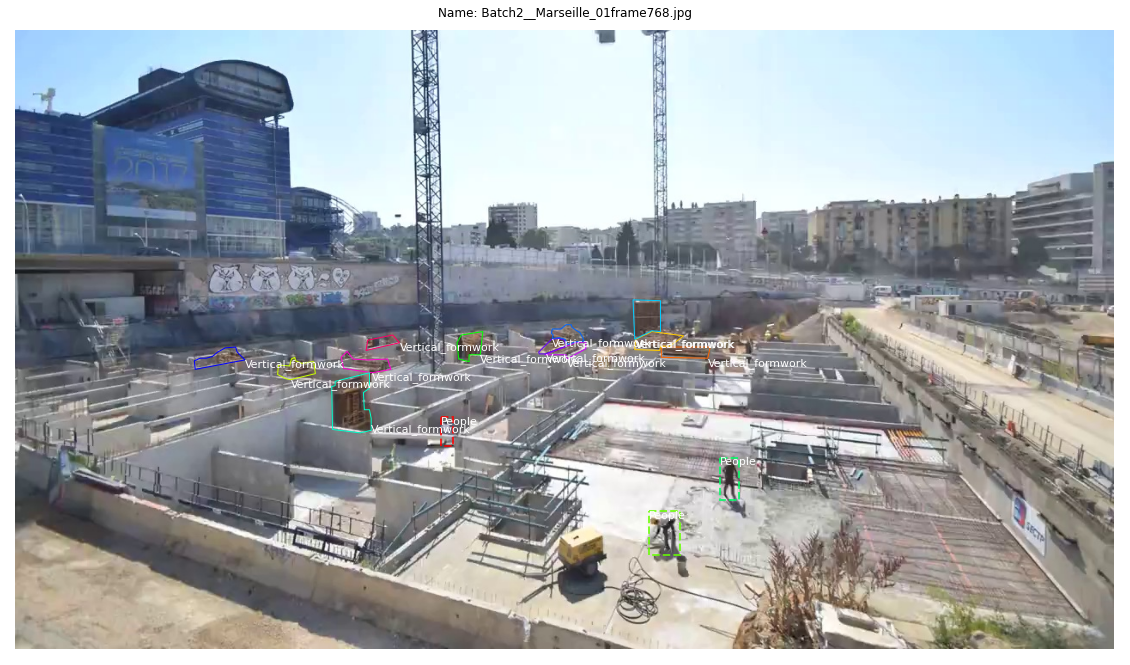

In [10]:
visualize_image_with_mask(TRAIN_DATA_NAMES[0])

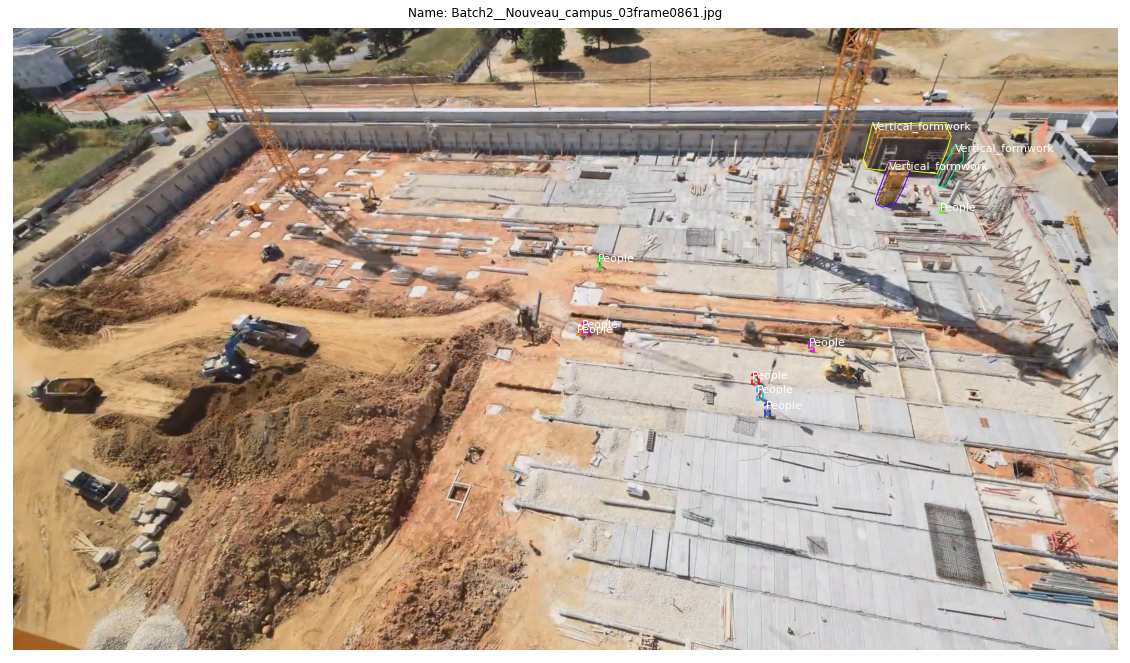

In [11]:
visualize_image_with_mask(TRAIN_DATA_NAMES[3])

# Use Pre-Trained Model

## Get Model from Git

In [12]:
!git clone "https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes.git" || true
!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'wastedata-Mask_RCNN-multiple-classes'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (151/151), 12.19 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [13]:
# Import local Mask RCNN
import sys
ROOT_DIR = os.path.abspath("./wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/")
sys.path.append(ROOT_DIR)


from mrcnn.config import Config
from mrcnn import model as modellib, utils
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class ChronsiteConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Chronsite"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 # a memory error occurs when IMAGES_PER_GPU is too high

    BACKBONE = "resnet50"

    # Number of classes (including background)
    NUM_CLASSES = 5  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    IMAGE_RESIZE_MODE = "crop"

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 400

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 40

## Utils

In [14]:
def draw_rectangle(mask, bbox):
    """Helper function for rendering."""
    y1, x1, y2, x2 = bbox[0][1], bbox[0][0], bbox[1][1], bbox[1][0]
    contour = [[x1, y1], [x1, y2], [x2, y2], [x2, y1]]
    contour = np.array(contour, dtype=np.int32)
    cv2.drawContours(mask, [contour], -1, (255), -1)
    return mask

def draw_polygon(mask, contour):
    """Helper function for rendering."""
    contour = np.array(contour, dtype=np.int32)
    cv2.drawContours(mask, [contour], -1, (255), -1)
    return mask

def convert_annotations(annotations, image_shape):
    """Convert masks from polygon to binary mask for training."""
    masks = []
    class_names = []
    for obj in annotations["objects"]:
        class_name = obj["classTitle"]
        mask = np.zeros(image_shape, dtype=np.int8)
        if (obj["geometryType"] == "rectangle"):
            mask = draw_rectangle(mask, obj['points']['exterior'])
        elif (obj["geometryType"] == "polygon"):
            mask = draw_polygon(mask, obj['points']['exterior'])
        masks.append(mask)
        class_names.append(class_name)
    masks = np.stack(masks, axis=2)
    return masks, class_names

## Dataset Loader

In [15]:
from mrcnn import utils as mrcnn_utils

class ChronsiteDataset(mrcnn_utils.Dataset):
    def __init__(self, sample_ids, image_path, label_path, verbose=False):
        super().__init__()
        self.sample_ids = sample_ids
        self.filename_for_image_id = []
        self.verbose = verbose
        self.source = "Chronsite"
        self.class_names_preset = np.array(['BG', 'Concrete_pump_hose',
            'Mixer_truck', 'People', 'Vertical_formwork'])
        self.image_path = image_path
        self.label_path = label_path
        
    def _get_id_of_class(self, clabel):
        if clabel not in self.class_names_preset:
            raise Exception(f'Class {clabel} not present in dataset classes: {self.class_names_preset}')
        return np.where(self.class_names_preset == clabel)[0][0]

    def load_image(self, image_id, zero_image=False):
        """ Load the images during training. """
        filename = self.filename_for_image_id[image_id]
        image = cv2.imread(GDRIVE_PATH + self.image_path + filename)
        #  could not broadcast input array from shape (1024,1856,3) into shape (1088,1920,3)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def load_mask(self, image_id):
        """ Load the masks during training."""
        filename = self.filename_for_image_id[image_id]
        with open(GDRIVE_PATH + self.label_path + filename + ".json") as f:
            annotations = json.load(f)
        shape = (annotations['size']['height'], annotations['size']['width'])
        #print("SHAPE", shape)
        masks, class_names = convert_annotations(annotations, shape)
        class_ids = np.array([self._get_id_of_class(c) for c in class_names], dtype=np.int32)
        #print("CLASS IDS", class_ids)
        return masks, class_ids

    def load_kernel(self) -> None:
        """ Load the metadate before training. """
        self.classes = set()
        for filename in tqdm(self.sample_ids):
            try:
                image_path = GDRIVE_PATH + TRAIN_DATA_IMAGES + filename
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                with open(GDRIVE_PATH + TRAIN_DATA_LABELS + filename + ".json") as f:
                  annotations = json.load(f)
                if (len(annotations["objects"]) == 0):
                    print(f'Skip sample {filename}, no gt_objects')
                    continue
                for obj in annotations["objects"]:
                    self.classes.update({obj["classTitle"]})
                self.add_image(
                  source=self.source,
                  image_id=filename,
                  sub_class_label="ConstructionSite",
                  path=image_path,
                  image_size=image.shape,
                )
                self.filename_for_image_id.append(filename)
            except Exception as e:
                print(f'EXCP: {e} during handling {filename}')
                continue
        for i, c in enumerate(list(self.class_names_preset[1:])):
            self.add_class(self.source, i + 1, c)
        self.prepare()
        return

In [16]:
import mrcnn.model as modellib
from mrcnn import visualize

MODEL_DIR = "logs/"
COCO_MODEL_PATH = COCO_PATH + "mask_rcnn_coco.h5"

# Split into Training & Tet Set
random.shuffle(TRAIN_DATA_NAMES)
train_data = TRAIN_DATA_NAMES[:int((len(TRAIN_DATA_NAMES)+1)*.80)] #Remaining 80% to training set
test_data = TRAIN_DATA_NAMES[int((len(TRAIN_DATA_NAMES)+1)*.80):] #Splits 20% data to test set

# Dataset
dataset_train = ChronsiteDataset(train_data, TRAIN_DATA_IMAGES, TRAIN_DATA_LABELS)
dataset_train.load_kernel()
dataset_val = ChronsiteDataset(test_data, TRAIN_DATA_IMAGES, TRAIN_DATA_LABELS)
dataset_val.load_kernel()

HEAD_EPOCHS = 10
ALL_EPOCHS = 30 #15 #100

config = ChronsiteConfig()
config.STEPS_PER_EPOCH = 400
config.LEARNING_RATE = 0.001
config.NAME = "Chronsite"
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Load weights trained on the MS COCO
# Skip layers that are different due to the different number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True,
  exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
           "mrcnn_bbox", "mrcnn_mask"])

# Finetune the header layers
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=HEAD_EPOCHS,
            layers='heads')

# Finetune all layers
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=ALL_EPOCHS,
            layers="all")

  4%|▍         | 47/1248 [00:46<18:46,  1.07it/s]

Skip sample Batch2__Devisubox2_06frame6307.jpg, no gt_objects


  5%|▌         | 68/1248 [01:05<16:58,  1.16it/s]

Skip sample Batch2__Devisubox2_06frame6569.jpg, no gt_objects


  7%|▋         | 86/1248 [01:26<27:08,  1.40s/it]

Skip sample Batch2__Roissy_02frame1784.jpg, no gt_objects


 25%|██▌       | 312/1248 [05:25<14:33,  1.07it/s]

Skip sample Batch2__Roissy_02frame1704.jpg, no gt_objects


 32%|███▏      | 397/1248 [06:56<17:52,  1.26s/it]

Skip sample Batch2__Devisubox2_06frame5641.jpg, no gt_objects


 43%|████▎     | 534/1248 [09:27<11:15,  1.06it/s]

Skip sample Batch2__Roissy_02frame1700.jpg, no gt_objects


 44%|████▍     | 553/1248 [09:49<12:55,  1.12s/it]

EXCP: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/Case3/Case3 - WSM/Detection_Train_Set/Detection_Train_Set_Json/Batch2__Roissy_02frame926.jpg.json' during handling Batch2__Roissy_02frame926.jpg


 45%|████▌     | 563/1248 [09:59<11:18,  1.01it/s]

Skip sample Batch2__Roissy_02frame1740.jpg, no gt_objects


 46%|████▌     | 570/1248 [10:06<10:01,  1.13it/s]

Skip sample Batch2__Devisubox2_06frame7351.jpg, no gt_objects


 50%|█████     | 629/1248 [11:08<12:13,  1.19s/it]

Skip sample Batch2__Roissy_02frame1935.jpg, no gt_objects


 55%|█████▌    | 691/1248 [12:10<08:16,  1.12it/s]

Skip sample Batch2__Devisubox2_06frame6730.jpg, no gt_objects


 65%|██████▌   | 817/1248 [14:17<06:20,  1.13it/s]

Skip sample Batch2__Roissy_02frame1706.jpg, no gt_objects


 68%|██████▊   | 849/1248 [14:51<08:11,  1.23s/it]

Skip sample Batch2__Roissy_02frame1803.jpg, no gt_objects


 74%|███████▎  | 918/1248 [15:56<04:46,  1.15it/s]

Skip sample Batch2__Roissy_02frame1665.jpg, no gt_objects


 76%|███████▌  | 949/1248 [16:27<05:50,  1.17s/it]

Skip sample Batch2__Devisubox2_06frame6406.jpg, no gt_objects


 90%|█████████ | 1129/1248 [19:30<01:52,  1.06it/s]

Skip sample Batch2__Devisubox2_06frame6181.jpg, no gt_objects


 92%|█████████▏| 1152/1248 [19:53<01:42,  1.07s/it]

Skip sample Batch2__Roissy_02frame1661.jpg, no gt_objects


 92%|█████████▏| 1154/1248 [19:54<01:21,  1.15it/s]

EXCP: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/Case3/Case3 - WSM/Detection_Train_Set/Detection_Train_Set_Json/Batch2__Roissy_02frame928.jpg.json' during handling Batch2__Roissy_02frame928.jpg


 93%|█████████▎| 1161/1248 [20:01<01:32,  1.07s/it]

Skip sample Batch2__Roissy_02frame1702.jpg, no gt_objects


 29%|██▉       | 90/311 [01:39<05:00,  1.36s/it]

Skip sample Batch2__Devisubox2_06frame6505.jpg, no gt_objects


 89%|████████▉ | 278/311 [04:57<00:40,  1.22s/it]

Skip sample Batch2__Roissy_02frame1658.jpg, no gt_objects


100%|██████████| 311/311 [05:31<00:00,  1.07s/it]

Streaming output truncated to the last 5000 lines.
348/400 [=========================>....] - ETA: 1:09 - loss: 1.3701 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4953 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.3297SHAPE (720, 1280)
SHAPE (1080, 1616)
352/400 [=========================>....] - ETA: 1:04 - loss: 1.3737 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.2264 - mrcnn_bbox_loss: 0.2902 - mrcnn_mask_loss: 0.3297SHAPE (720, 1280)
SHAPE (720, 1280)
355/400 [=========================>....] - ETA: 1:00 - loss: 1.3727 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.4981 - mrcnn_class_loss: 0.2261 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.3296SHAPE (1080, 1920)
SHAPE (1080, 1920)
358/400 [=========================>....] - ETA: 56s - loss: 1.3700 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.4963 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.3292SHAPE (720, 1280)
SHAPE (1080, 1920)
363/400 [=============

In [18]:
CHECKPOINT_EPOCH = 30
# Latest model branch
directory = 'logs/'
MODEL_BRANCH = max([os.path.join(directory, d) for d in os.listdir(directory)], key=os.path.getmtime)
print("Latest model branch", MODEL_BRANCH)

config = ChronsiteConfig()
config.IMAGE_RESIZE_MODE = "pad64"
config.IMAGE_SHAPE = [1024, 1280, 3]
config.NAME = "Chronsite"
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)
model_path = os.path.join(MODEL_BRANCH, f"mask_rcnn_chronsite_{CHECKPOINT_EPOCH:04d}.h5")
model.load_weights(model_path, by_name=True)

Latest model branch logs/chronsite20220216T1559
Re-starting from epoch 30


Detecting on Image ID 74
SHAPE (720, 1280)


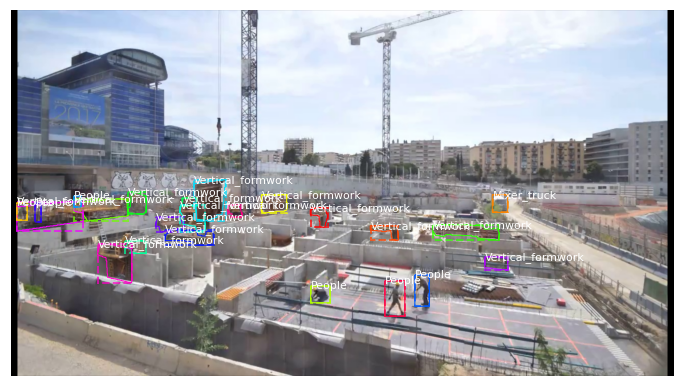

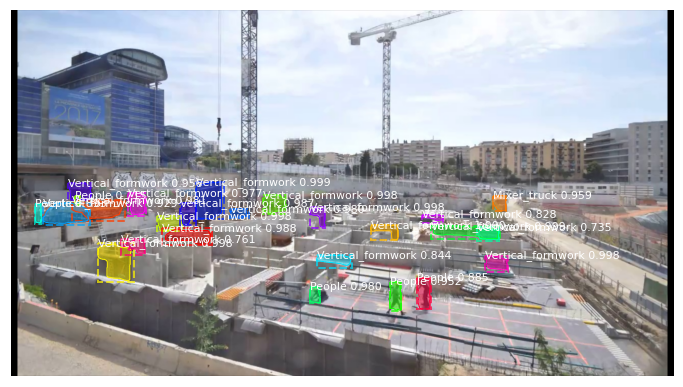




Detecting on Image ID 121
SHAPE (1080, 1920)


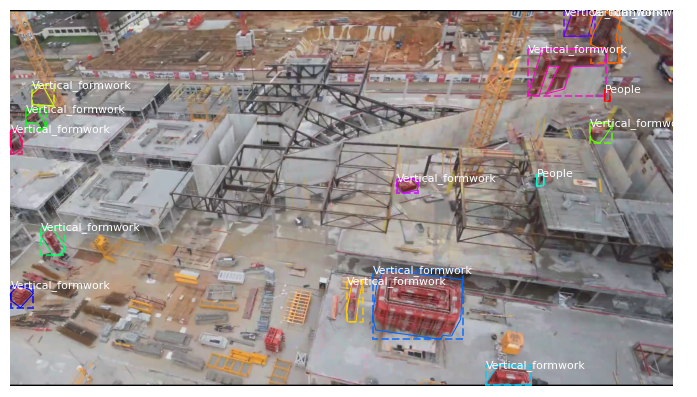

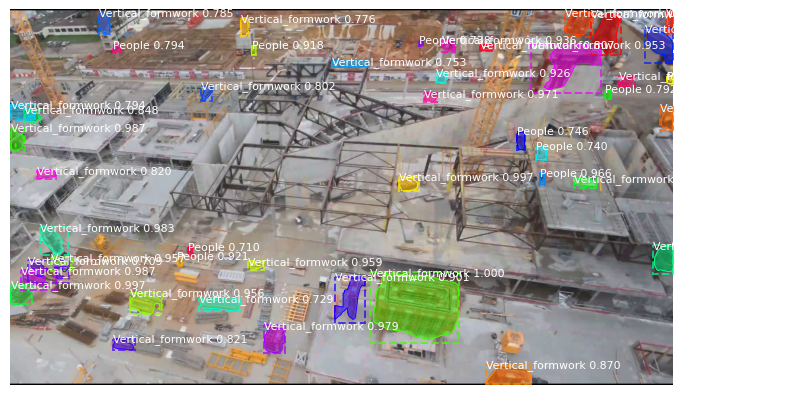




Detecting on Image ID 6
SHAPE (720, 1280)


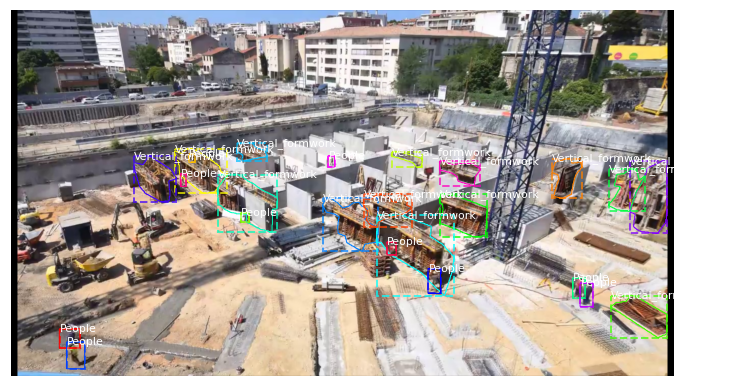

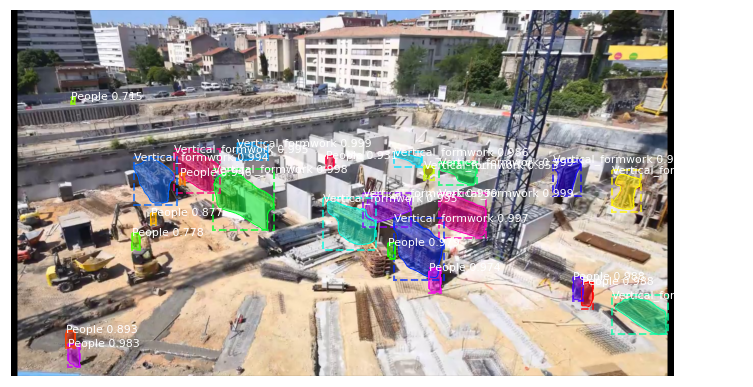




Detecting on Image ID 213
SHAPE (720, 1280)


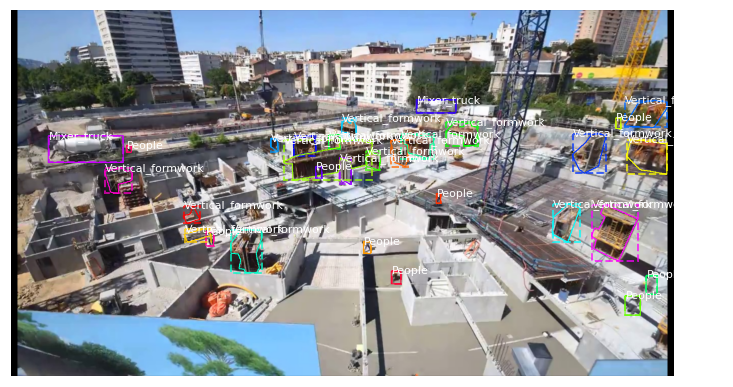

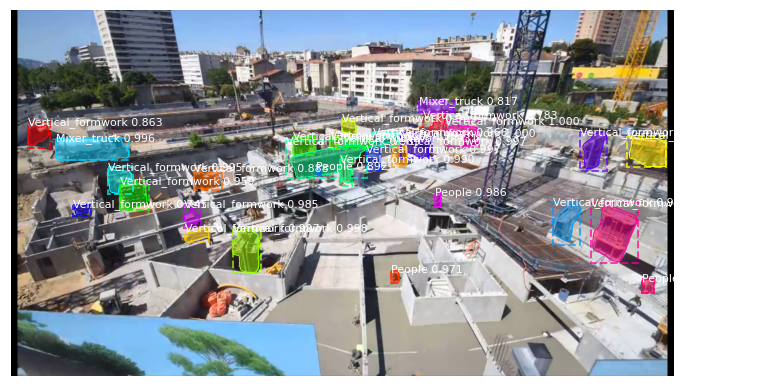

In [20]:
random.seed(100)
dataset_inference = dataset_val

# Visualize some random images
for i in range(4):
  # Test on a random image
  image_id = random.choice(dataset_inference.image_ids)
  print("Detecting on Image ID", image_id)
  original_image, image_meta, \
    gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_inference, config, \
                                      image_id, use_mini_mask=False)
  results = model.detect([original_image], verbose=0)

  # Original
  visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
      dataset_inference.class_names_preset, figsize=(12, 12))
  
  # Prediction
  r = results[0]
  visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
    dataset_inference.class_names_preset, r['scores'], figsize=(12, 12))
  print("\n\n")